<a href="https://colab.research.google.com/github/rsabilio/ia024-projeto-rag/blob/main/4_rag_recursive_retriever.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instruções

* Estratégia
    * Recursive Retriever
    * Reranker com monoPTT5-large

# Instalando pacotes

In [ ]:
!pip install -q llama-index llama-index-llms-groq sentence-transformers llama-index-embeddings-huggingface transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 64.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.8/130.8 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.4/327.4 kB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 853.2/853.2 kB 62.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 69.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install -q rerankers

# Importando pacotes

In [ ]:
import os
from google.colab import userdata

os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')

In [ ]:
from llama_index.core import Settings, VectorStoreIndex, PromptTemplate
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.llms.groq import Groq
from llama_index.core.schema import TextNode, IndexNode
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core.retrievers import RecursiveRetriever
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.evaluation import FaithfulnessEvaluator, CorrectnessEvaluator, RelevancyEvaluator
from llama_index.core.response.notebook_utils import display_source_node, display_response
from llama_index.core import StorageContext, load_index_from_storage
from rerankers import Reranker

import glob
import json
import pandas as pd
from rich.pretty import pprint
from tqdm import tqdm
from IPython.display import Markdown, display
import shutil
import pickle
import torch

import nest_asyncio
nest_asyncio.apply()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# GitHub

In [ ]:
GITHUB_TOKEN      = userdata.get('GITHUB_TOKEN')
GITHUB_USER_EMAIL = userdata.get('GITHUB_USER_EMAIL')
GITHUB_USER_NAME  = userdata.get('GITHUB_USER_NAME')

!git config --global user.email '''{GITHUB_USER_EMAIL}'''
!git config --global user.name '''{GITHUB_USER_NAME}'''

# Clonar o repositório GitHub
!git clone https://{GITHUB_TOKEN}@github.com/rsabilio/ia024-projeto-rag.git

Cloning into 'ia024-projeto-rag'...
remote: Enumerating objects: 8675, done.
remote: Counting objects: 100% (224/224), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 8675 (delta 152), reused 219 (delta 149), pack-reused 8451
Receiving objects: 100% (8675/8675), 1.27 GiB | 35.89 MiB/s, done.
Resolving deltas: 100% (3673/3673), done.
Updating files: 100% (5813/5813), done.
Filtering content: 100% (1211/1211), 140.28 MiB | 10.50 MiB/s, done.


In [ ]:
DATA_DIR = '/content/ia024-projeto-rag'

## Configurando Git para arquivos maiores quem 100MB

In [ ]:
!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash

In [ ]:
!apt-get install git-lfs

In [ ]:
%cd /content/ia024-projeto-rag

!git lfs install
!git lfs track "*.json"
!git add .gitattributes

In [ ]:
%cd /content/ia024-projeto-rag

!git pull origin main
!git add .
!git commit -m "Configurando Git para arquivos maiores"
!git lfs push --all origin main
!git push origin main


## Funções

In [ ]:
def save_on_git(msg):

    %cd /content/ia024-projeto-rag

    !git remote set-url origin https://{GITHUB_TOKEN}@github.com/rsabilio/ia024-projeto-rag

    !git pull origin main

    !git add .

    !git commit -m '''{msg}'''

    !git push origin main

In [ ]:
def update_local_repo():
    %cd /content/ia024-projeto-rag

    !git remote set-url origin https://{GITHUB_TOKEN}@github.com/rsabilio/ia024-projeto-rag

    !git pull origin main

In [ ]:
update_local_repo()

# Carregando modelos

In [ ]:
embed_model = HuggingFaceEmbedding(model_name="alfaneo/bertimbau-base-portuguese-sts", device=device)

Settings.embed_model = embed_model
Settings.llm         = Groq(model="llama3-70b-8192")

ranker = Reranker(
        "unicamp-dl/monoptt5-large",
        inputs_template="Pergunta: {query} Documento: {text} Relevante:",
        dtype=torch.bfloat16, #float32,
        device=device,
    )


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.39k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/857 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/538 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/438k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Loading T5Ranker model unicamp-dl/monoptt5-large
Using dtype torch.bfloat16
Loading model unicamp-dl/monoptt5-large, this might take a while...
Using device cuda.
Using dtype torch.bfloat16.


config.json:   0%|          | 0.00/732 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/756k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


T5 true token set to ▁Sim
T5 false token set to ▁Não
Returning normalised scores...
Inputs template set to Pergunta: {query} Documento: {text} Relevante:


# Preparando dados

In [ ]:
def get_json_files(directory, pattern="*.json"):
    return glob.glob(os.path.join(directory, pattern))

def get_nodes():
  base_nodes     = []

  print(f"Carregando Estatuto e Organizações Didáticas...")
  directory_path = f"{DATA_DIR}/2-dataset/"
  json_files     = get_json_files(directory_path, pattern="*-nivel-subsecao.json")

  for json_file in json_files:

      print(f"Carregando: {json_file}")
      with open(json_file, 'r') as f:
          documento = json.load(f)

      documento_titulo = documento['titulo']

      for parte in documento['partes']:
          metadata = {}
          metadata["documento"] = documento_titulo
          metadata["titulo"]    = ""
          metadata["capitulo"]  = ""
          metadata["seção"]     = ""
          metadata["subseção"]  = ""

          titulo_nome    = parte['titulo_nome']
          titulo_artigos = parte['titulo_artigos']
          capitulos      = parte['capitulos']

          metadata["titulo"] = titulo_nome
          if len(titulo_artigos) > 0:
              for artigo in titulo_artigos:
                  node = TextNode(text=artigo, metadata=metadata)
                  base_nodes.append(node)

          if len(capitulos) == 0:
              continue

          for capitulo in capitulos:
              cap_titulo  = capitulo['capitulo_nome']
              cap_artigos = capitulo['capitulo_artigos']

              metadata["capitulo"] = cap_titulo
              metadata["seção"]     = ""
              metadata["subseção"]  = ""
              for artigo in cap_artigos:
                  node = TextNode(text=artigo, metadata=metadata)
                  base_nodes.append(node)

              if len(capitulo['secoes']) == 0:
                  continue

              for secao in capitulo['secoes']:
                  secao_titulo  = secao['secao_nome']
                  secao_artigos = secao['secao_artigos']

                  metadata["seção"] = secao_titulo
                  for artigo in secao_artigos:
                      node = TextNode(text=artigo, metadata=metadata)
                      base_nodes.append(node)

                  if len(secao['subsecoes']) == 0:
                      continue

                  for subsecao in secao['subsecoes']:
                      subsecao_titulo  = subsecao['subsecao_nome']
                      subsecao_artigos = subsecao['subsecao_artigos']

                      metadata["subseção"] = subsecao_titulo
                      for artigo in subsecao_artigos:
                          node = TextNode(text=artigo, metadata=metadata)
                          base_nodes.append(node)

      print(f"{len(base_nodes)} nodes carregados")

  print(f"Carregando portarias: {directory_path}")
  directory_path = f"{DATA_DIR}/2-dataset/2-boituva/portarias"
  json_files     = get_json_files(directory_path)

  for json_file in json_files:
      print(f"Carregando: {json_file}")
      with open(json_file, 'r') as f:
          documento = json.load(f)

      for portaria in documento:

          portaria_titulo = portaria['titulo']
          portaria_inicio = portaria['inicio']
          portaria_fim    = portaria['fim']


          metadata = {}
          #metadata["campus"]    = portaria['campus']
          metadata["documento"] = portaria_titulo

          node = TextNode(text=portaria_inicio, metadata=metadata)
          base_nodes.append(node)

          for artigo in portaria['artigos']:
              node = TextNode(text=artigo, metadata=metadata)
              base_nodes.append(node)

          if portaria['fim'] != "":
              node = TextNode(text=portaria_fim, metadata=metadata)
              base_nodes.append(node)

      print(f"{len(base_nodes)} nodes carregados")

  for i, node in enumerate(base_nodes):
      node.id_ = f"node_{i}"

  print(f"Total de nodes carregados: {len(base_nodes)}")
  return base_nodes

Carregando Estatuto e Organizações Didáticas...
Carregando: /content/ia024-projeto-rag/2-dataset/organização_didática_dos_cursos_de_graduação-nivel-subsecao.json
204 nodes carregados
Carregando: /content/ia024-projeto-rag/2-dataset/estatuto-nivel-subsecao.json
254 nodes carregados
Carregando: /content/ia024-projeto-rag/2-dataset/organização_didática_da_educação_básica-nivel-subsecao.json
494 nodes carregados
Carregando portarias: /content/ia024-projeto-rag/2-dataset/
Carregando: /content/ia024-projeto-rag/2-dataset/2-boituva/portarias/boituva-2014.json
626 nodes carregados
Carregando: /content/ia024-projeto-rag/2-dataset/2-boituva/portarias/boituva-2024.json
791 nodes carregados
Carregando: /content/ia024-projeto-rag/2-dataset/2-boituva/portarias/boituva-2018.json
1132 nodes carregados
Carregando: /content/ia024-projeto-rag/2-dataset/2-boituva/portarias/boituva-2021.json
1600 nodes carregados
Carregando: /content/ia024-projeto-rag/2-dataset/2-boituva/portarias/boituva-2023.json
2057 no

# Criando indice

In [ ]:
index_dir = f"{DATA_DIR}/4-vector_index"

if os.path.exists(index_dir):
  print("Carregando Index existente")
  storage_context = StorageContext.from_defaults(persist_dir=index_dir)
  index = load_index_from_storage(storage_context)

  with open(f"{DATA_DIR}/4-vector_index/all_nodes_dict.pkl", "rb") as f:
      all_nodes_dict = pickle.load(f)

else:
  print("Criando indice")
  sub_chunk_sizes  = [256, 512]
  sub_node_parsers = [SentenceSplitter(chunk_size=c, chunk_overlap=20) for c in sub_chunk_sizes]

  base_nodes = get_nodes()
  all_nodes  = []
  for base_node in base_nodes:

      for n in sub_node_parsers:
          sub_nodes  = n.get_nodes_from_documents([base_node])
          sub_inodes = [IndexNode.from_text_node(sn, base_node.node_id) for sn in sub_nodes]
          all_nodes.extend(sub_inodes)

      original_node = IndexNode.from_text_node(base_node, base_node.node_id)
      all_nodes.append(original_node)

  all_nodes_dict = {n.node_id: n for n in all_nodes}

  with open(f"{DATA_DIR}/4-vector_index/all_nodes_dict.pkl", "wb") as f:
      pickle.dump(all_nodes_dict, f)

  print(f"Total de nodes: {len(all_nodes)}")

  index = VectorStoreIndex(all_nodes, show_progress=True)
  index.storage_context.persist(index_dir)

  # Caminho da pasta que você deseja compactar
  pasta_para_compactar = f"{DATA_DIR}/4-vector_index"

  # Caminho e nome do arquivo zip de saída (sem a extensão .zip)
  arquivo_zip_saida = f"{DATA_DIR}/4-vector_index"

  # Cria o arquivo zip
  shutil.make_archive(arquivo_zip_saida, 'zip', pasta_para_compactar)

  save_on_git("Salvando o índice de vetores")


Carregando Index existente


# Recursive Retriever - Sem ReRanker

In [ ]:
vector_retriever = index.as_retriever(similarity_top_k=20)

retriever = RecursiveRetriever(
    "vector",
    retriever_dict={"vector": vector_retriever},
    node_dict=all_nodes_dict,
    verbose=True,
)

query_engine = RetrieverQueryEngine.from_args(
    retriever=retriever,
    verbose=True
)

In [ ]:
#query = "O IFSP tem só ensino médio? Além de responder à pergunta, informe o documento, o Capítulo e o Artigo de referência."
query = "Qual o nome do IFSP?"
response = query_engine.query(query)
display_response(response)

Retrieving with query id None: Qual o nome do IFSP?
Retrieved node with id, entering: node_2011
Retrieving with query id node_2011: Qual o nome do IFSP?
Retrieved node with id, entering: node_1733
Retrieving with query id node_1733: Qual o nome do IFSP?
Retrieved node with id, entering: node_731
Retrieving with query id node_731: Qual o nome do IFSP?
Retrieved node with id, entering: node_1606
Retrieving with query id node_1606: Qual o nome do IFSP?
Retrieved node with id, entering: node_1887
Retrieving with query id node_1887: Qual o nome do IFSP?
Retrieved node with id, entering: node_1672
Retrieving with query id node_1672: Qual o nome do IFSP?
Retrieved node with id, entering: node_1744
Retrieving with query id node_1744: Qual o nome do IFSP?
Retrieved node with id, entering: node_760
Retrieving with query id node_760: Qual o nome do IFSP?
Retrieved node with id, entering: node_1626
Retrieving with query id node_1626: Qual o nome do IFSP?
Retrieved node with id, entering: node_633


**`Final Response:`** The name of the IFSP is not explicitly mentioned in the provided context. However, based on the document structure and the URLs mentioned (e.g., https://suap.ifsp.edu.br/autenticar-documento/), it can be inferred that the IFSP stands for Instituto Federal de Educação, Ciência e Tecnologia de São Paulo.

# Implementando o Rerank

In [ ]:
import time
import random
import gc

In [ ]:
def rerank(query, nodes, top_k=5):
    docs = [node.get_content() for node in nodes]

    results = ranker.rank(query, docs)

    scored_nodes = list(zip(nodes, [result.score for result in results]))
    scored_nodes.sort(key=lambda x: x[1], reverse=True)

    top_nodes = [node for node, score in scored_nodes[:top_k]]

    # Free up memory
    torch.cuda.empty_cache()
    gc.collect()

    return top_nodes

In [ ]:
class RerankedRetrieverQueryEngine(RetrieverQueryEngine):
    def __init__(self, retriever, reranker, top_k=5, **kwargs):
        super().__init__(retriever=retriever, **kwargs)
        self.reranker = reranker
        self.top_k = top_k

    def query(self, query_str):
        response = super().query(query_str)
        nodes_to_rerank = response.source_nodes
        top_reranked_nodes = self.reranker(query_str, nodes_to_rerank, self.top_k)
        response.source_nodes = top_reranked_nodes
        return response

In [ ]:
def display_prompt_dict(prompts_dict):
    for k, p in prompts_dict.items():
        text_md = f"**Prompt Key**: {k} " f"**Text:** "
        display(Markdown(text_md))
        print(p.get_template())
        display(Markdown(""))

In [ ]:
def get_contexts(response):
    contexts = []
    for node in response.source_nodes:
        metadata = ', '.join(node.metadata.values())
        context  = node.get_content()
        contexts.append(f"Fonte: {metadata} # Contextos: {context}")
    return contexts

In [ ]:
def parse_retry_after(error_message):
    try:
        error_data = json.loads(error_message)
        return error_data['error']['message'].split('Please try again in ')[1].split('s.')[0]
    except Exception as e:
        print(f"Failed to parse retry-after duration: {e}")
        return None

In [ ]:
vector_retriever = index.as_retriever(similarity_top_k=20)

retriever = RecursiveRetriever(
    "vector",
    retriever_dict={"vector": vector_retriever},
    node_dict=all_nodes_dict,
)

In [ ]:
query_engine_with_rerank = RerankedRetrieverQueryEngine(
    retriever=retriever,
    reranker=rerank,
    top_k=5
)

In [ ]:
new_summary_tmpl_str = ("""
Context information is below.
---------------------
{context_str}
---------------------
Given the context information and not prior knowledge, answer the query.
If you have an answer, provide the source of the answer, such as the document, title, chapter, or article when available.
Otherwise, just leave the source field blank.
It is important that you use the same language as the query.
Query: {query_str}
Source:
Answer:
"""
)

new_refine_tmpl_str = ("""
The original query is as follows: {query_str}
We have provided an existing answer: {existing_answer}
We have the opportunity to refine the existing answer (only if needed) with some more context below.
------------
{context_msg}
------------
Given the new context, refine the original answer to better answer the query. If the context isn't useful, return the original answer.
Do not add other information, such as 'The refined answer remains the same' or 'Justification', besides the answer and the source.
If you have an answer, provide the source of the answer, such as the document, title, chapter, or article when available.
Otherwise, just leave the source field blank.
It is important that you use the same language as the query.

Refined Answer:

"""
)

new_summary_tmpl = PromptTemplate(new_summary_tmpl_str)
new_refine_tmpl_str = PromptTemplate(new_refine_tmpl_str)

query_engine_with_rerank.update_prompts(
    {"response_synthesizer:text_qa_template": new_summary_tmpl
     , "response_synthesizer:refine_template" : new_refine_tmpl_str}
)

display_prompt_dict(query_engine_with_rerank.get_prompts())


**Prompt Key**: response_synthesizer:text_qa_template **Text:** 


Context information is below.
---------------------
{context_str}
---------------------
Given the context information and not prior knowledge, answer the query.
If you have an answer, provide the source of the answer, such as the document, title, chapter, or article when available.
Otherwise, just leave the source field blank.
It is important that you use the same language as the query.
Query: {query_str}
Source:
Answer:



**Prompt Key**: response_synthesizer:refine_template **Text:** 


The original query is as follows: {query_str}
We have provided an existing answer: {existing_answer}
We have the opportunity to refine the existing answer (only if needed) with some more context below.
------------
{context_msg}
------------
Given the new context, refine the original answer to better answer the query. If the context isn't useful, return the original answer.
Do not add other information, such as 'The refined answer remains the same' or 'Justification', besides the answer and the source.
If you have an answer, provide the source of the answer, such as the document, title, chapter, or article when available.
Otherwise, just leave the source field blank.
It is important that you use the same language as the query.

Refined Answer:




# Avaliação

In [ ]:
def evaluate_pair(pair, max_retries=5):
    faith_evaluator     = FaithfulnessEvaluator()
    relevancy_evaluator = RelevancyEvaluator()
    correct_evaluator   = CorrectnessEvaluator()
    result = {}

    index = pair['index']
    query = pair['question']
    ground_truth = pair['ground_truth']
    response     = pair['response']

    result['index']        = index
    result['question']     = query
    result['ground_truth'] = ground_truth
    result['answer']       = response.response
    result['contexts']     = get_contexts(response)

    retries = 0
    while retries < max_retries:
        try:

            # Avaliando Faithfulness
            eval_result = faith_evaluator.evaluate_response(response=response)
            result['faithfulness'] = eval_result.score

            # Avaliando Relevancy
            eval_result = relevancy_evaluator.evaluate_response(query=query, response=response)
            result['relevancy'] = eval_result.score

            # Avaliando Correctness
            eval_result = correct_evaluator.evaluate(
                query=query,
                response=response.response,
                reference=ground_truth,
            )
            result['correctness'] = eval_result.score
            result['correctness_feedback'] = eval_result.feedback

            return result

        except Exception as e:
            error_message = str(e)
            if 'rate limit' in error_message.lower():
                retry_after = parse_retry_after(error_message)
                if retry_after:
                    wait_time = float(retry_after)
                else:
                    wait_time = 2 ** retries + random.uniform(0, 1)
                print(f"Rate limit reached. Retrying in {wait_time:.2f} seconds...")
                time.sleep(wait_time)
                retries += 1
            else:
                raise

    raise Exception("Max retries exceeded")

## Teste de avaliação

In [ ]:
pairs = [{
            "question": "Qual o nome do IFSP?",
            "answer": "Instituto Federal de Educação, Ciência e Tecnologia de São Paulo.  Referência: Estatuto, Título I, Capítulo I, Art. 1º"
         }
         ,{
            "question": "Quais são os campi do IFSP?",
            "answer": """II. Campus São Paulo, situado na Rua Pedro Vicente, 625, Canindé, São Paulo.
III. Campus Cubatão, situado na Rua Maria Cristina, 50, Jardim Casqueiro, Cubatão.
IV. Campus Sertãozinho, situado na Rua Américo Ambrósio, 269, Jardim Canaã,
Sertãozinho.
V. Campus Guarulhos, situado na Avenida Salgado Filho, 2501, Bairro Vila Rio de
Janeiro, Guarulhos.
VI. Campus São João da Boa Vista, situado no Acesso Dr. João Batista Merlin, s/ n.º,
Jardim Itália, São João da Boa Vista.
VII. Campus Caraguatatuba, situado na Avenida Rio Grande do Norte, 450, Indaiá,
Caraguatatuba.
VIII. Campus Bragança Paulista, situado na Avenida Francisco Samuel Lucchesi Filho,
770, Penha, Bragança Paulista.
IX. Campus Salto, situado na Rua Rio Branco, 1780, Vila Teixeira, Salto.
X. Campus São Roque, situado na Rodovia Quintino de Lima, 2100, Jardim Conceição,
São Roque.
XI. Campus São Carlos, situado na Rodovia Washington Luís, km 235 AT-6, Sala 119,
São Carlos.
XII. Campus Campos do Jordão, situado na Rua Monsenhor José Vita, 280, Vila
Abernéssia, Campos do Jordão.
XIII. Campus Barretos, situado na Avenida C-1, Bairro Ide Daher, Barretos.
XIV. Campus Suzano, situado na Avenida Mogi das Cruzes, 1.501, Parque Suzano,
Suzano.
XV. Campus Campinas, situado na Rodovia D. Pedro I – SP 65 – KM 143,6, Amarais,
Campinas;
XVI. Campus Catanduva, situado na Avenida Imperatriz, s/ n.º, Distrito Industrial,
Catanduva.
XVII. Campus Avaré, situado na Avenida Professor Celso Ferreira da Silva, s/ n.º, Jardim
Europa, Avaré.
XVIII. Campus Araraquara, situado no Ramal de Acesso Engenheiro Heitor de Souza
Pinheiro, Araraquara.
XIX. Campus Itapetininga, situado na Avenida João Olímpio de Oliveira, Bairro Assen,
Itapetininga.
XX. Campus Birigui, situado na Rua Pedro Cavalo, 709, Residencial Portal da Pérola II,
Birigui.
XXI. Campus Votuporanga, situado na Rua Pará, s/ n.º, Chácara Aviação, Votuporanga.
XXII. Campus Registro, situado na Rua Clara Gianotti de Souza, 5.180, Agrochá,
Registro.
XXIII. Campus Presidente Epitácio, situado na Rua Rua José Ramos Júnior, nº 27-50,
Jardim Tropical, Presidente Epitácio.
XXIV. Campus Piracicaba, situado na Rodovia Deputado Laércio Corte, s/ n.º, Bairro
Santa Rosa, Piracicaba.
XXV. Campus Hortolândia, situado na Rodovia Municipal TeodorCondiev, 1896,
Hortolândia.
XXVI. Campus Boituva, situado na Avenida Zélia de Lima Rosa, nº 100, Portal dos
Pássaros, Boituva.
XXVII. Campus Capivari, situado na Avenida Ênio Pires de Camargo, 2971, São João
Batista, Capivari.
XXVIII. Campus Matão, situado na Rua José Bonifácio, 1176, Centro, Matão.
XXIX. Campus São José dos Campos, situado na Rodovia Presidente Dutra s/n – km 145,
Jardim Diamante, São José dos Campos.

Referência: Estatuto, Título I, Capítulo I, Art. 1º, §2º
"""
         }
         ,{
            "question": "Quantos campi o IFSP tem? Informe onde você encontrou essa informação",
            "answer": "O IFSP tem 28 campi. Referência: Estatuto, Capítulo I, Art. 1º, §2º"
         }
        ]

#query = "O IFSP tem só ensino médio? Além de responder à pergunta, informe o documento, o Capítulo e o Artigo de referência."
#query = "Quais artigos do Estatuto dizem que o IFSP oferece mestrado e doutorado?"
#query = "O que diz o Art 6º do estatuto do IFSP?"
#query = "O Art 4º do estatuto do IFSP é sobre o que?"

In [ ]:
pair = pairs[0]
response = query_engine_with_rerank.query(pair['question'])
pprint(response)

Scoring...:   0%|          | 0/1 [00:00<?, ?it/s]

Response(
│   response='The answer is not explicitly stated in the provided context information. However, based on the document titles and URLs, it can be inferred that the IFSP stands for "Instituto Federal de Educação, Ciência e Tecnologia de São Paulo" (Federal Institute of Education, Science and Technology of São Paulo).\n\nSource: (inferred from document titles and URLs)\n\nAnswer: Instituto Federal de Educação, Ciência e Tecnologia de São Paulo',
│   source_nodes=[
│   │   NodeWithScore(
│   │   │   node=IndexNode(
│   │   │   │   id_='node_2011',
│   │   │   │   embedding=None,
│   │   │   │   metadata={'documento': 'PORTARIA Nº 83/2023 - DRG/BTV/IFSP DE 22 DE DEZEMBRO DE 2023'},
│   │   │   │   excluded_embed_metadata_keys=[],
│   │   │   │   excluded_llm_metadata_keys=[],
│   │   │   │   relationships={},
│   │   │   │   text='De ciência.\n\nPublique-se.\n\nDocumento assinado eletronicamente.\n\nFELIPE AUGUSTO FERREIRA DE ALMEIDA\n\nPublicado no site institucional em 22.12.2023\n\nDocumento assinado eletronicamente por: Felipe Augusto Ferreira de Almeida, DIRETOR(A) GERAL - CD2 - DRG/BTV, em 22/12/2023 19:56:52.\n\nEste documento foi emitido pelo SUAP em 22/12/2023. Para comprovar sua autenticidade, faça a leitura do QRCode ao lado ou acesse https://suap.ifsp.edu.br/autenticar-documento/ e forneça os dados abaixo:\n\nCódigo Verificador: 675075\n\nCódigo de Autenticação: d5f62998bd\n\nPORTARIA Nº 83/2023 - DRG/BTV/IFSP',
│   │   │   │   mimetype='text/plain',
│   │   │   │   start_char_idx=None,
│   │   │   │   end_char_idx=None,
│   │   │   │   text_template='{metadata_str}\n\n{content}',
│   │   │   │   metadata_template='{key}: {value}',
│   │   │   │   metadata_seperator='\n',
│   │   │   │   index_id='node_2011',
│   │   │   │   obj=None
│   │   │   ),
│   │   │   score=0.7487946977255814
│   │   ),
│   │   NodeWithScore(
│   │   │   node=IndexNode(
│   │   │   │   id_='node_1733',
│   │   │   │   embedding=None,
│   │   │   │   metadata={'documento': 'PORTARIA Nº 60/2023 - DRG/BTV/IFSP DE 29 DE SETEMBRO DE 2023'},
│   │   │   │   excluded_embed_metadata_keys=[],
│   │   │   │   excluded_llm_metadata_keys=[],
│   │   │   │   relationships={},
│   │   │   │   text='De ciência.\n\nPublique-se.\n\nDocumento assinado eletronicamente.\n\nFELIPE AUGUSTO FERREIRA DE ALMEIDA\n\nPublicado no site institucional em 30.09.2023\n\nDocumento assinado eletronicamente por:\n\nFelipe Augusto Ferreira de Almeida , DIRETOR(A) GERAL - CD2 - DRG/BTV, em 29/09/2023 20:14:08.\n\nFelipe Augusto Ferreira de Almeida  DIRETOR(A) GERAL - CD2 - DRG/BTV\n\nEste documento foi emiBdo pelo SUAP em 29/09/2023. Para comprovar sua autenBcidade, faça a leitura do QRCode ao lado ou acesse hPps://suap.ifsp.edu.br/autenBcar-documento/ e forneça os dados abaixo:\n\nCódigo Verificador: 625965\n\nCódigo de AutenBcação: 59d4b15cc7\n\nPORTARIA Nº 60/2023 - DRG/BTV/IFSP\n\nPORTARIA Nº 60/2023 - DRG/BTV/IFSP',
│   │   │   │   mimetype='text/plain',
│   │   │   │   start_char_idx=None,
│   │   │   │   end_char_idx=None,
│   │   │   │   text_template='{metadata_str}\n\n{content}',
│   │   │   │   metadata_template='{key}: {value}',
│   │   │   │   metadata_seperator='\n',
│   │   │   │   index_id='node_1733',
│   │   │   │   obj=None
│   │   │   ),
│   │   │   score=0.7470045477047844
│   │   ),
│   │   NodeWithScore(
│   │   │   node=IndexNode(
│   │   │   │   id_='node_731',
│   │   │   │   embedding=None,
│   │   │   │   metadata={'documento': 'PORTARIA Nº 17/2024 - DRG/BTV/IFSP DE 7 DE MARÇO DE 2024'},
│   │   │   │   excluded_embed_metadata_keys=[],
│   │   │   │   excluded_llm_metadata_keys=[],
│   │   │   │   relationships={},
│   │   │   │   text='De ciência.\n\nPublique-se.\n\nDocumento assinado eletronicamente.\n\nFELIPE AUGUSTO FERREIRA DE ALMEIDA\n\nPublicado no site institucional em 06.03.2024\n\n# Documento assinado eletronicamente por:\n\nFelipe Augusto Ferreira de Almeida\n\nFelipe Augusto Ferreira de Almeida, DIRETOR(A) GERAL - CD2 - DRG/BTV, em

## Realizando consultas do arquivo de Testes

In [ ]:
df = pd.read_csv(f"{DATA_DIR}/3-questions_answers/test_dataset_100.csv")
df

,question,answer,context,reference,document
0,Quem são os servidores designados para constit...,"Fernando Vernal Salina Giorjety Licorini Dias,...","Art 20 - DESIGNAR, os servidores abaixo relaci...","Portaria nº 1.324, de 26 de março de 2014, Art...",boituva_portarias
1,O que é mobilidade de estudantes no IFSP?,A mobilidade de estudantes é a possibilidade d...,Art 199 - A mobilidade de estudantes poderá se...,"Organização Didática da Educação Básica, Títul...",od_edu_basica
2,Quais são os membros designados para compor a ...,"Jaime Martimiano Junior, Cristiane Vega Parise...",Art 1º - Altera em partes a PORTARIA BTV.0080/...,"PORTARIA BTV.0080/2018, de 06 de julho de 2018...",boituva_portarias
3,Quem são os membros designados para compor a C...,"Os membros designados são Felipe Gobo Bruno, M...","Art 1º - DESIGNAR, os membros abaixo relaciona...","PORTARIA BTV.0057/2020, DE 23 DE JULHO DE 2020...",boituva_portarias
4,Quais são os objetivos do Estágio Profissional...,Os objetivos do Estágio Profissional Supervisi...,Art 144 - São objetivos do estágio supervision...,"Organização Didática da Educação Básica, Títul...",od_edu_basica
...,...,...,...,...,...
95,Quem é o responsável pela coordenação do Comit...,A coordenação do Comitê é responsável por orga...,Art 2º - Ficará a cargo da Coordenação do Comi...,"Portaria nº 3.903, de 04 de novembro de 2015, ...",boituva_portarias
96,Quem é o servidor designado para desempenhar a...,"Ricardo José Correa, Advogado, matrícula SIAPE...",A PRESIDENTE DA COMISSÃO DE PROCESSO ADMINISTR...,"Portaria nº 1.970, de 28 de junho de 2018, Art...",boituva_portarias
97,Quais são os membros da Comissão de Elaboração...,Os membros da Comissão são: JAIR MANOEL CASQUE...,"Art 2.º - DESIGNAR, os servidores abaixo relac...","PORTARIA BTV.0060/2020, DE 24 DE JULHO DE 2020...",boituva_portarias
98,Quem é o responsável pela designação de servid...,O Diretor Geral do Campus Boituva do Instituto...,"O DIRETOR GERAL DO CAMPUS BOITUVA, DO INSTITUT...","PORTARIA BTV.0062/2018, DE 18 DE JUNHO DE 2018...",boituva_portarias


In [ ]:
if os.path.exists(f"{DATA_DIR}/5-evaluations/results-query-recursive.pkl"):
    with open(f"{DATA_DIR}/5-evaluations/results-query-recursive.pkl", "rb") as f:
        dados_consultas = pickle.load(f)
else:
    dados_consultas = []

for index, row in df[71:].iterrows():
    print(f"Consultando indice: {index}")
    result       = {}
    query        = row['question']
    ground_truth = f"{row['answer']} \nFonte: {row['reference']}"

    result['index']        = index
    result['question']     = query
    result['ground_truth'] = ground_truth

    # Fazendo consulta
    response           = query_engine_with_rerank.query(query)
    result['response'] = response

    dados_consultas.append(result)
    with open(f"{DATA_DIR}/5-evaluations/results-query-recursive.pkl", "wb") as f:
        pickle.dump(dados_consultas, f)

    if index % 3 == 0:
      save_on_git(f"Salvando os dados das consultas usando Rerank/RecursiveRetrieval. Amostra: {index}")

Consultando indice: 71


Scoring...:   0%|          | 0/1 [00:00<?, ?it/s]

Consultando indice: 72


Scoring...:   0%|          | 0/1 [00:00<?, ?it/s]

/content/ia024-projeto-rag
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 32 (delta 16), reused 25 (delta 9), pack-reused 0
Unpacking objects: 100% (32/32), 24.95 KiB | 456.00 KiB/s, done.
From https://github.com/rsabilio/ia024-projeto-rag
 * branch            main       -> FETCH_HEAD
   de3c755..29870af  main       -> origin/main
Updating de3c755..29870af
Fast-forward
 5-evaluations/df_result-bm25-2.pkl | Bin 173735 -> 384731 bytes
 1 file changed, 0 insertions(+), 0 deletions(-)
[main fed8597] Salvando os dados das consultas usando Rerank/RecursiveRetrieval. Amostra: 72
 1 file changed, 0 insertions(+), 0 deletions(-)
 rewrite 5-evaluations/results-query-recursive.pkl (71%)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 17.32 KiB | 2.47 MiB/s, done.
Total 4 (d

Scoring...:   0%|          | 0/1 [00:00<?, ?it/s]

Consultando indice: 74


Scoring...:   0%|          | 0/1 [00:00<?, ?it/s]

Consultando indice: 75


Scoring...:   0%|          | 0/1 [00:00<?, ?it/s]

/content/ia024-projeto-rag
From https://github.com/rsabilio/ia024-projeto-rag
 * branch            main       -> FETCH_HEAD
Already up to date.
[main 2b457f0] Salvando os dados das consultas usando Rerank/RecursiveRetrieval. Amostra: 75
 1 file changed, 0 insertions(+), 0 deletions(-)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 2.40 KiB | 491.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/rsabilio/ia024-projeto-rag
   fed8597..2b457f0  main -> main
Consultando indice: 76


Scoring...:   0%|          | 0/1 [00:00<?, ?it/s]

Consultando indice: 77


Scoring...:   0%|          | 0/1 [00:00<?, ?it/s]

Consultando indice: 78


Scoring...:   0%|          | 0/1 [00:00<?, ?it/s]

/content/ia024-projeto-rag
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 4 (delta 2), reused 4 (delta 2), pack-reused 0
Unpacking objects: 100% (4/4), 1.96 KiB | 200.00 KiB/s, done.
From https://github.com/rsabilio/ia024-projeto-rag
 * branch            main       -> FETCH_HEAD
   2b457f0..c732b88  main       -> origin/main
Updating 2b457f0..c732b88
Fast-forward
 5-evaluations/df_result-bm25-2.pkl | Bin 384731 -> 410809 bytes
 1 file changed, 0 insertions(+), 0 deletions(-)
[main b651c88] Salvando os dados das consultas usando Rerank/RecursiveRetrieval. Amostra: 78
 1 file changed, 0 insertions(+), 0 deletions(-)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 2.76 KiB | 707.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas

Scoring...:   0%|          | 0/1 [00:00<?, ?it/s]

Consultando indice: 80


Scoring...:   0%|          | 0/1 [00:00<?, ?it/s]

Consultando indice: 81


Scoring...:   0%|          | 0/1 [00:00<?, ?it/s]

/content/ia024-projeto-rag
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 4 (delta 2), reused 4 (delta 2), pack-reused 0
Unpacking objects: 100% (4/4), 2.97 KiB | 304.00 KiB/s, done.
From https://github.com/rsabilio/ia024-projeto-rag
 * branch            main       -> FETCH_HEAD
   b651c88..17203a8  main       -> origin/main
Updating b651c88..17203a8
Fast-forward
 5-evaluations/df_result-bm25-2.pkl | Bin 410809 -> 434360 bytes
 1 file changed, 0 insertions(+), 0 deletions(-)
[main b363e51] Salvando os dados das consultas usando Rerank/RecursiveRetrieval. Amostra: 81
 1 file changed, 0 insertions(+), 0 deletions(-)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 2.46 KiB | 630.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas

Scoring...:   0%|          | 0/1 [00:00<?, ?it/s]

Consultando indice: 83


Scoring...:   0%|          | 0/1 [00:00<?, ?it/s]

Consultando indice: 84


Scoring...:   0%|          | 0/1 [00:00<?, ?it/s]

/content/ia024-projeto-rag
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 4 (delta 2), reused 4 (delta 2), pack-reused 0
Unpacking objects: 100% (4/4), 2.47 KiB | 253.00 KiB/s, done.
From https://github.com/rsabilio/ia024-projeto-rag
 * branch            main       -> FETCH_HEAD
   b363e51..6d25060  main       -> origin/main
Updating b363e51..6d25060
Fast-forward
 5-evaluations/df_result-bm25-2.pkl | Bin 434360 -> 458161 bytes
 1 file changed, 0 insertions(+), 0 deletions(-)
[main 3f507e1] Salvando os dados das consultas usando Rerank/RecursiveRetrieval. Amostra: 84
 1 file changed, 0 insertions(+), 0 deletions(-)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 2.39 KiB | 488.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas

Scoring...:   0%|          | 0/1 [00:00<?, ?it/s]

Consultando indice: 86


Scoring...:   0%|          | 0/1 [00:00<?, ?it/s]

Consultando indice: 87


Scoring...:   0%|          | 0/1 [00:00<?, ?it/s]

/content/ia024-projeto-rag
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 4 (delta 2), reused 4 (delta 2), pack-reused 0
Unpacking objects: 100% (4/4), 2.78 KiB | 189.00 KiB/s, done.
From https://github.com/rsabilio/ia024-projeto-rag
 * branch            main       -> FETCH_HEAD
   3f507e1..71c097b  main       -> origin/main
Updating 3f507e1..71c097b
Fast-forward
 5-evaluations/df_result-bm25-2.pkl | Bin 458161 -> 482150 bytes
 1 file changed, 0 insertions(+), 0 deletions(-)
[main 7da0507] Salvando os dados das consultas usando Rerank/RecursiveRetrieval. Amostra: 87
 1 file changed, 0 insertions(+), 0 deletions(-)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 2.83 KiB | 578.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas

Scoring...:   0%|          | 0/1 [00:00<?, ?it/s]

Consultando indice: 89


Scoring...:   0%|          | 0/1 [00:00<?, ?it/s]

Consultando indice: 90


Scoring...:   0%|          | 0/1 [00:00<?, ?it/s]

/content/ia024-projeto-rag
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 8 (delta 4), reused 7 (delta 3), pack-reused 0
Unpacking objects: 100% (8/8), 4.64 KiB | 189.00 KiB/s, done.
From https://github.com/rsabilio/ia024-projeto-rag
 * branch            main       -> FETCH_HEAD
   7da0507..6062d0d  main       -> origin/main
Updating 7da0507..6062d0d
Fast-forward
 5-evaluations/df_result-bm25-2.pkl | Bin 482150 -> 518256 bytes
 1 file changed, 0 insertions(+), 0 deletions(-)
[main e3d448f] Salvando os dados das consultas usando Rerank/RecursiveRetrieval. Amostra: 90
 1 file changed, 0 insertions(+), 0 deletions(-)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 1.75 KiB | 358.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving del

Scoring...:   0%|          | 0/1 [00:00<?, ?it/s]

Consultando indice: 92


Scoring...:   0%|          | 0/1 [00:00<?, ?it/s]

Consultando indice: 93


Scoring...:   0%|          | 0/1 [00:00<?, ?it/s]

/content/ia024-projeto-rag
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 4 (delta 2), reused 4 (delta 2), pack-reused 0
Unpacking objects: 100% (4/4), 3.18 KiB | 191.00 KiB/s, done.
From https://github.com/rsabilio/ia024-projeto-rag
 * branch            main       -> FETCH_HEAD
   e3d448f..5c19278  main       -> origin/main
Updating e3d448f..5c19278
Fast-forward
 5-evaluations/df_result-bm25-2.pkl | Bin 518256 -> 541920 bytes
 1 file changed, 0 insertions(+), 0 deletions(-)
[main 73d8ed2] Salvando os dados das consultas usando Rerank/RecursiveRetrieval. Amostra: 93
 1 file changed, 0 insertions(+), 0 deletions(-)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 2.38 KiB | 486.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas

Scoring...:   0%|          | 0/1 [00:00<?, ?it/s]

Consultando indice: 95


Scoring...:   0%|          | 0/1 [00:00<?, ?it/s]

Consultando indice: 96


Scoring...:   0%|          | 0/1 [00:00<?, ?it/s]

/content/ia024-projeto-rag
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 4 (delta 2), reused 4 (delta 2), pack-reused 0
Unpacking objects: 100% (4/4), 2.31 KiB | 197.00 KiB/s, done.
From https://github.com/rsabilio/ia024-projeto-rag
 * branch            main       -> FETCH_HEAD
   73d8ed2..0debd2f  main       -> origin/main
Updating 73d8ed2..0debd2f
Fast-forward
 5-evaluations/df_result-bm25-2.pkl | Bin 541920 -> 560880 bytes
 1 file changed, 0 insertions(+), 0 deletions(-)
[main 904c7c0] Salvando os dados das consultas usando Rerank/RecursiveRetrieval. Amostra: 96
 1 file changed, 0 insertions(+), 0 deletions(-)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 3.14 KiB | 535.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas

Scoring...:   0%|          | 0/1 [00:00<?, ?it/s]

Consultando indice: 98


Scoring...:   0%|          | 0/1 [00:00<?, ?it/s]

Consultando indice: 99


Scoring...:   0%|          | 0/1 [00:00<?, ?it/s]

/content/ia024-projeto-rag
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 4 (delta 2), reused 4 (delta 2), pack-reused 0
Unpacking objects: 100% (4/4), 2.29 KiB | 90.00 KiB/s, done.
From https://github.com/rsabilio/ia024-projeto-rag
 * branch            main       -> FETCH_HEAD
   904c7c0..0cf0bcb  main       -> origin/main
Updating 904c7c0..0cf0bcb
Fast-forward
 5-evaluations/df_result-bm25-2.pkl | Bin 560880 -> 584779 bytes
 1 file changed, 0 insertions(+), 0 deletions(-)
[main 6a4e4ff] Salvando os dados das consultas usando Rerank/RecursiveRetrieval. Amostra: 99
 1 file changed, 0 insertions(+), 0 deletions(-)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 1.60 KiB | 328.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas:

## Avaliando as respostas

In [ ]:
df_perguntas = pd.DataFrame(dados_consultas)
df_perguntas

,index,question,ground_truth,response
0,0,Quem são os servidores designados para constit...,"Fernando Vernal Salina Giorjety Licorini Dias,...",Os servidores designados para constituírem o N...
1,1,O que é mobilidade de estudantes no IFSP?,A mobilidade de estudantes é a possibilidade d...,A mobilidade de estudantes no IFSP é a possibi...
2,2,Quais são os membros designados para compor a ...,"Jaime Martimiano Junior, Cristiane Vega Parise...",Os membros designados para compor a Subcomissã...
3,3,Quem são os membros designados para compor a C...,"Os membros designados são Felipe Gobo Bruno, M...",Os membros designados para compor a Comissão E...
4,4,Quais são os objetivos do Estágio Profissional...,Os objetivos do Estágio Profissional Supervisi...,Os objetivos do Estágio Profissional Supervisi...
...,...,...,...,...
95,95,Quem é o responsável pela coordenação do Comit...,A coordenação do Comitê é responsável por orga...,Felipe Ferreira de Lara\nSource: PORTARIA BTV ...
96,96,Quem é o servidor designado para desempenhar a...,"Ricardo José Correa, Advogado, matrícula SIAPE...",Não há resposta para essa pergunta com base no...
97,97,Quais são os membros da Comissão de Elaboração...,Os membros da Comissão são: JAIR MANOEL CASQUE...,Os membros da Comissão de Elaboração e Impleme...
98,98,Quem é o responsável pela designação de servid...,O Diretor Geral do Campus Boituva do Instituto...,O responsável pela designação de servidores pa...


In [ ]:
# Salvando os dados após cada iteração
with open(f"{DATA_DIR}/5-evaluations/results-query-recursive.pkl", "rb") as f:
    dados_consultas = pickle.load(f)

print(f"Quantidade de avaliações: {len(dados_consultas)}")


#carregando arquivos de dados e log
if os.path.exists(f"{DATA_DIR}/5-evaluations/results-eval-recursive.pkl"):
    with open(f"{DATA_DIR}/5-evaluations/results-eval-recursive.pkl", "rb") as f:
        eval_result = pickle.load(f)
else:
    eval_result = []

if os.path.exists(f"{DATA_DIR}/5-evaluations/amostras-avaliadas.pkl"):
    with open(f"{DATA_DIR}/5-evaluations/amostras-avaliadas.pkl", "rb") as f:
        amostras_avaliadas = pickle.load(f)
else:
    amostras_avaliadas = []

for i, pair in enumerate(dados_consultas):

    if pair['index'] in amostras_avaliadas:
        print(f"*** Amostra {pair['index']} já avaliada")
        continue

    print(f"Processando amostra: {pair['index']}")
    result = evaluate_pair(pair)

    eval_result.append(result)
    with open(f"{DATA_DIR}/5-evaluations/results-eval-recursive.pkl", "wb") as f:
        pickle.dump(eval_result, f)


    amostras_avaliadas.append(pair['index'])
    with open(f"{DATA_DIR}/5-evaluations/amostras-avaliadas.pkl", "wb") as f:
        pickle.dump(amostras_avaliadas, f)

    if i % 2 == 0:
        save_on_git(f"Salvando os dados das avaliações usando Rerank/RecursiveRetrieval. Amostra: {pair['index']}")


In [ ]:
with open(f"{DATA_DIR}/5-evaluations/results-eval-recursive.pkl", "rb") as f:
  resultados = pickle.load(f)

resultados

[{'index': 0,
  'question': 'Quem são os servidores designados para constituírem o Núcleo Docente Estruturante do Curso de Tecnologia de Análise e Desenvolvimento de Sistemas do Campus Boituva?',
  'ground_truth': 'Fernando Vernal Salina Giorjety Licorini Dias, Francisco Cesar de Oliveira, Thiago Pedro Donadon Homem e Felipe Nunes Gaia. \nFonte: Portaria nº 1.324, de 26 de março de 2014, Art. 20',
  'answer': 'Os servidores designados para constituírem o Núcleo Docente Estruturante do Curso de Tecnologia de Análise e Desenvolvimento de Sistemas do Campus Boituva são: Marcelo Figueiredo Polido, Giorjety Licorini Dias, Luiz Egidio Costa Cunha, Felipe Alexandre Cardoso Pazinatto e Ricardo Pezzotti Schefer.\n\nSource: documento: PORTARIA Nº 27/2023 - DRG/BTV/IFSP DE 31 DE MAIO DE 2023.',
  'contexts': ['Fonte: PORTARIA Nº 82/2023 - DRG/BTV/IFSP DE 21 DE DEZEMBRO DE 2023 # Contextos: |Art 1º - DESIGNAR, os servidores abaixo relacionados para constituírem o Núcleo Docente Estruturante do Cur

In [ ]:
df_resultados = pd.DataFrame(resultados).drop(columns='index')
df_resultados.to_csv(f"{DATA_DIR}/5-evaluations/eval_recursive.csv", index=False)
df_resultados

,question,ground_truth,answer,contexts,faithfulness,relevancy,correctness,correctness_feedback
0,Quem são os servidores designados para constit...,"Fernando Vernal Salina Giorjety Licorini Dias,...",Os servidores designados para constituírem o N...,[Fonte: PORTARIA Nº 82/2023 - DRG/BTV/IFSP DE ...,1.0,1.0,3.0,The generated answer is relevant to the user q...
1,O que é mobilidade de estudantes no IFSP?,A mobilidade de estudantes é a possibilidade d...,A mobilidade de estudantes no IFSP é a possibi...,[Fonte: Organização Didática dos Cursos de Gra...,1.0,1.0,4.5,The generated answer is almost identical to th...
2,Quais são os membros designados para compor a ...,"Jaime Martimiano Junior, Cristiane Vega Parise...",Os membros designados para compor a Subcomissã...,"[Fonte: PORTARIA BTV.0109/2018, DE 13 DE SETEM...",1.0,1.0,5.0,The generated answer is fully correct and rele...
3,Quem são os membros designados para compor a C...,"Os membros designados são Felipe Gobo Bruno, M...",Os membros designados para compor a Comissão E...,[Fonte: PORTARIA Nº 66/2023 - DRG/BTV/IFSP DE ...,1.0,1.0,1.0,The generated answer is not relevant to the us...
4,Quais são os objetivos do Estágio Profissional...,Os objetivos do Estágio Profissional Supervisi...,Os objetivos do Estágio Profissional Supervisi...,[Fonte: PORTARIA Nº 30/2024 - DRG/BTV/IFSP DE ...,1.0,1.0,5.0,The generated answer is almost identical to th...
...,...,...,...,...,...,...,...,...
95,Quem é o responsável pela coordenação do Comit...,A coordenação do Comitê é responsável por orga...,Felipe Ferreira de Lara\nSource: PORTARIA BTV ...,[Fonte: PORTARIA Nº 8/2023 - DRG/BTV/IFSP DE 2...,1.0,1.0,5.0,The generated answer directly answers the user...
96,Quem é o servidor designado para desempenhar a...,"Ricardo José Correa, Advogado, matrícula SIAPE...",Não há resposta para essa pergunta com base no...,[Fonte: PORTARIA Nº 33/2023 - DRG/BTV/IFSP DE ...,0.0,1.0,1.0,The generated answer is not relevant to the us...
97,Quais são os membros da Comissão de Elaboração...,Os membros da Comissão são: JAIR MANOEL CASQUE...,Os membros da Comissão de Elaboração e Impleme...,"[Fonte: PORTARIA BTV.0038/2021, DE 20 DE MAIO ...",1.0,1.0,3.0,The generated answer is relevant to the user q...
98,Quem é o responsável pela designação de servid...,O Diretor Geral do Campus Boituva do Instituto...,O responsável pela designação de servidores pa...,[Fonte: PORTARIA Nº 65/2023 - DRG/BTV/IFSP DE ...,0.0,0.0,4.5,The generated answer is highly relevant and co...


In [ ]:
save_on_git("Salvando resultados na avaliação do Rerank/RecursiveRetrieval")

/content/ia024-projeto-rag
From https://github.com/rsabilio/ia024-projeto-rag
 * branch            main       -> FETCH_HEAD
Already up to date.
[main 9fd6e06] Salvando resultados na avaliação do Rerank/RecursiveRetrieval
 3 files changed, 488 insertions(+)
 create mode 100644 5-evaluations/eval_recursive.csv
Enumerating objects: 10, done.
Counting objects: 100% (10/10), done.
Delta compression using up to 2 threads
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 139.68 KiB | 4.50 MiB/s, done.
Total 6 (delta 4), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (4/4), completed with 4 local objects.
To https://github.com/rsabilio/ia024-projeto-rag
   02f3b76..9fd6e06  main -> main


In [ ]:
df_resultados.describe()

,faithfulness,relevancy,correctness
count,100.000000,100.000000,100.000000
mean,0.640000,0.690000,2.940000
std,0.482418,0.464823,1.694137
min,0.000000,0.000000,1.000000
25%,0.000000,0.000000,1.000000
50%,1.000000,1.000000,3.000000
75%,1.000000,1.000000,4.500000
max,1.000000,1.000000,5.000000


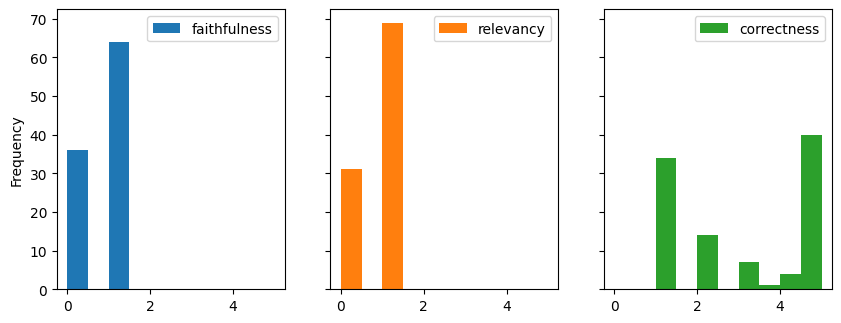

In [ ]:
df_resultados.plot(kind='hist', subplots=True, layout=(2, 3), figsize=(10, 8), sharey=True);

In [ ]:
from sklearn.preprocessing import MinMaxScaler

df_normalizado = df_resultados.copy()


# Inicializar o MinMaxScaler
scaler = MinMaxScaler()

# Normalizar a coluna 'A'
df_normalizado['correctness_normalized'] = scaler.fit_transform(df_normalizado[['correctness']])

df_normalizado.describe()


,faithfulness,relevancy,correctness,correctness_normalized
count,100.000000,100.000000,100.000000,100.000000
mean,0.640000,0.690000,2.940000,0.485000
std,0.482418,0.464823,1.694137,0.423534
min,0.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000
50%,1.000000,1.000000,3.000000,0.500000
75%,1.000000,1.000000,4.500000,0.875000
max,1.000000,1.000000,5.000000,1.000000


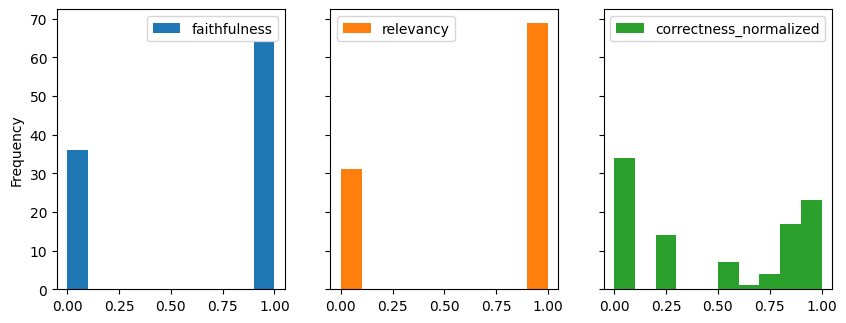

In [ ]:
df_normalizado.drop(columns='correctness').plot(kind='hist', subplots=True, layout=(2, 3), figsize=(10, 8), sharey=True);
